In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/신용거래탐지/train.csv') # Train
train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [5]:
train_df.isnull().sum()

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64

In [3]:
val_df = pd.read_csv('/content/drive/MyDrive/신용거래탐지/val.csv') # Validation
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [6]:
val_df.isnull().sum()

ID       0
V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
V29      0
V30      0
Class    0
dtype: int64

# **데이터 전처리**

변수의 개수를 줄이기 위하는 방법으로 이상치 탐지이므로 Class가 1인 경우와 0인 경우의 분포가 비슷하면 그 변수는 의미가 없다고 여기고 삭제해주기로 한다

In [7]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

v_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']

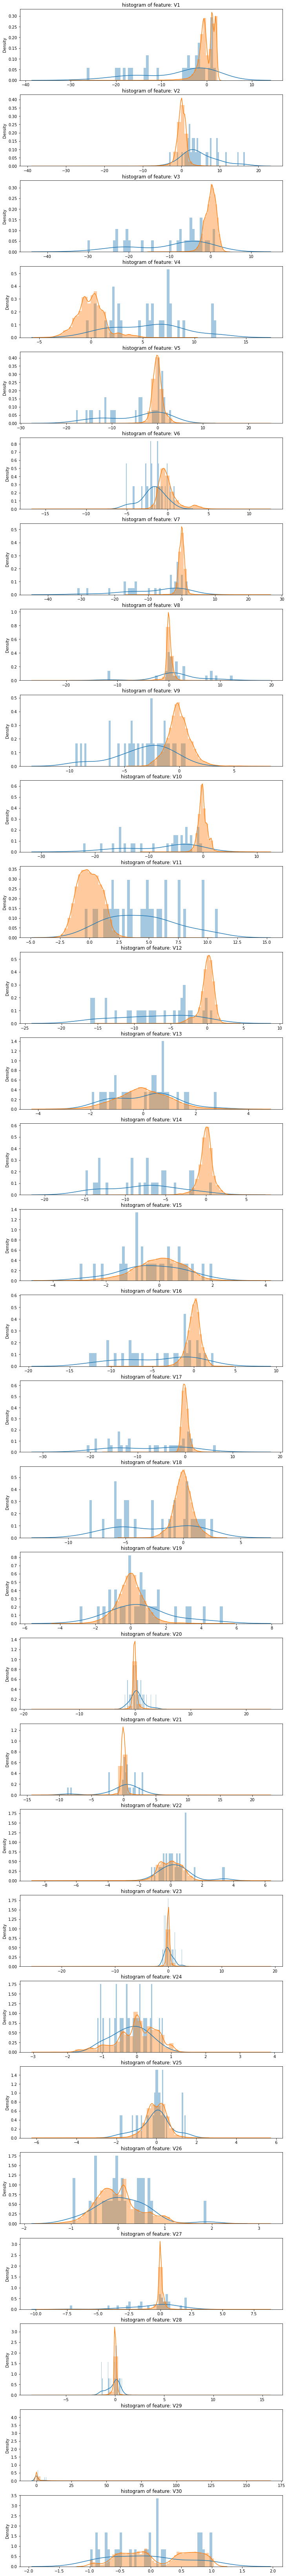

In [8]:
plt.figure(figsize=(12,30*4))
gs = gridspec.GridSpec(30, 1)
for i, cn in enumerate(val_df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(val_df[cn][val_df.Class == 1], bins=50)
    sns.distplot(val_df[cn][val_df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [9]:
new_val = val_df.drop(['V13','V15','V22','V24','V25','V26','V29','V30'],axis=1)
new_train = train_df.drop(['V13','V15','V22','V24','V25','V26','V29','V30'],axis=1)

ne_val = val_df.drop(['V13','V15','V22','V24','V25','V26','V29','V30'],axis=1)
ne_train = train_df.drop(['V13','V15','V22','V24','V25','V26','V29','V30'],axis=1)

그림을 기준으로 각 값들의 기준점을 정한다음 그 값을 기준으로 차이가 많이 나면 1로 아니면 0이 되도록 새로운 변수 Vn_을 만들어주었다

In [10]:
ne_val['V1_'] = new_val.V1.map(lambda x: 1 if x < -2.5 else 0)
ne_val['V2_'] = new_val.V2.map(lambda x: 1 if x > 2 else 0)
ne_val['V3_'] = new_val.V3.map(lambda x: 1 if x < -2.5 else 0)
ne_val['V4_'] = new_val.V4.map(lambda x: 1 if x > 2 else 0)
ne_val['V5_'] = new_val.V5.map(lambda x: 1 if x < -2.5 else 0)
ne_val['V6_'] = new_val.V6.map(lambda x: 1 if x < -1.5 else 0)
ne_val['V7_'] = new_val.V7.map(lambda x: 1 if x < -1.5 else 0)
ne_val['V8_'] = new_val.V8.map(lambda x: 1 if x > 1.5 else 0)
ne_val['V9_'] = new_val.V9.map(lambda x: 1 if x < -1.5 else 0)
ne_val['V10_'] = new_val.V10.map(lambda x: 1 if x < -1 else 0)
ne_val['V11_'] = new_val.V11.map(lambda x: 1 if x > 2 else 0)
ne_val['V12_'] = new_val.V12.map(lambda x: 1 if x < -1.5 else 0)
ne_val['V14_'] = new_val.V14.map(lambda x: 1 if x < -2 else 0)
ne_val['V16_'] = new_val.V16.map(lambda x: 1 if x < -2 else 0)
ne_val['V17_'] = new_val.V17.map(lambda x: 1 if x < -1 else 0)
ne_val['V18_'] = new_val.V18.map(lambda x: 1 if x < -1.5 else 0)
ne_val['V19_'] = new_val.V19.map(lambda x: 1 if x > 0.5 else 0)
ne_val['V20_'] = new_val.V20.map(lambda x: 1 if x > 0.5 else 0)
ne_val['V21_'] = new_val.V21.map(lambda x: 1 if x > 0.5 else 0)
ne_val['V23_'] = new_val.V23.map(lambda x: 1 if x < -0.5 else 0)
ne_val['V27_'] = new_val.V27.map(lambda x: 1 if x > 0.5 else 0)
ne_val['V28_'] = new_val.V28.map(lambda x: 1 if x < - 0.5 else 0)

ne_train['V1_'] = new_train.V1.map(lambda x: 1 if x < -2.5 else 0)
ne_train['V2_'] = new_train.V2.map(lambda x: 1 if x > 2 else 0)
ne_train['V3_'] = new_train.V3.map(lambda x: 1 if x < -2.5 else 0)
ne_train['V4_'] = new_train.V4.map(lambda x: 1 if x > 2 else 0)
ne_train['V5_'] = new_train.V5.map(lambda x: 1 if x < -2.5 else 0)
ne_train['V6_'] = new_train.V6.map(lambda x: 1 if x < -1.5 else 0)
ne_train['V7_'] = new_train.V7.map(lambda x: 1 if x < -1.5 else 0)
ne_train['V8_'] = new_train.V8.map(lambda x: 1 if x > 1.5 else 0)
ne_train['V9_'] = new_train.V9.map(lambda x: 1 if x < -1.5 else 0)
ne_train['V10_'] = new_train.V10.map(lambda x: 1 if x < -1 else 0)
ne_train['V11_'] = new_train.V11.map(lambda x: 1 if x > 2 else 0)
ne_train['V12_'] = new_train.V12.map(lambda x: 1 if x < -1.5 else 0)
ne_train['V14_'] = new_train.V14.map(lambda x: 1 if x < -2 else 0)
ne_train['V16_'] = new_train.V16.map(lambda x: 1 if x < -2 else 0)
ne_train['V17_'] = new_train.V17.map(lambda x: 1 if x < -1 else 0)
ne_train['V18_'] = new_train.V18.map(lambda x: 1 if x < -1.5 else 0)
ne_train['V19_'] = new_train.V19.map(lambda x: 1 if x > 0.5 else 0)
ne_train['V20_'] = new_train.V20.map(lambda x: 1 if x > 0.5 else 0)
ne_train['V21_'] = new_train.V21.map(lambda x: 1 if x > 0.5 else 0)
ne_train['V23_'] = new_train.V23.map(lambda x: 1 if x < -0.5 else 0)
ne_train['V27_'] = new_train.V27.map(lambda x: 1 if x > 0.5 else 0)
ne_train['V28_'] = new_train.V28.map(lambda x: 1 if x < - 0.5 else 0)

### **정규화하고 skew 처리해주기**

In [14]:
from sklearn.preprocessing import StandardScaler

stand_train = StandardScaler().fit_transform(ne_train)

In [15]:
stand_train.shape

(113842, 45)

In [16]:
new_val = ne_val.drop(['Class'],axis=1)
stand_val = StandardScaler().fit_transform(new_val)

In [17]:
new_val.shape

(28462, 45)

In [18]:
stand_train.shape

(113842, 45)

In [25]:
col = ne_train.columns

In [26]:
cols = new_val.columns

In [27]:
stand_df= pd.DataFrame(stand_train, columns=col)

In [28]:
stand_val_df = pd.DataFrame(stand_val,columns=cols)

**정규화된 데이터 프레임 stand_df, stand_val_df**

In [29]:
numerical_feats = [ 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23',
       'V27', 'V28']
       
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(stand_df[col].skew()) 
         )

V1              Skewness: -3.43
V2              Skewness: -5.08
V3              Skewness: -1.88
V4              Skewness: 00.63
V5              Skewness: -0.71
V6              Skewness: 01.32
V7              Skewness: 00.58
V8              Skewness: -8.22
V9              Skewness: 00.63
V10             Skewness: 01.74
V11             Skewness: 00.28
V12             Skewness: -1.88
V14             Skewness: -1.50
V16             Skewness: -0.83
V17             Skewness: -2.19
V18             Skewness: -0.15
V19             Skewness: 00.08
V20             Skewness: -2.06
V21             Skewness: 03.60
V23             Skewness: -7.59
V27             Skewness: -2.33
V28             Skewness: 19.53


In [30]:
numerical_feats = [ 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23',
       'V27', 'V28']
       
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(stand_val_df[col].skew()) 
         )

V1              Skewness: -2.75
V2              Skewness: -3.59
V3              Skewness: -2.10
V4              Skewness: 00.68
V5              Skewness: -0.06
V6              Skewness: 01.19
V7              Skewness: -1.48
V8              Skewness: -5.75
V9              Skewness: 00.52
V10             Skewness: 00.90
V11             Skewness: 00.35
V12             Skewness: -2.18
V14             Skewness: -1.74
V16             Skewness: -1.08
V17             Skewness: -2.90
V18             Skewness: -0.20
V19             Skewness: 00.15
V20             Skewness: 01.10
V21             Skewness: 05.47
V23             Skewness: -0.79
V27             Skewness: -2.71
V28             Skewness: 02.50


** 값이 3보다 큰v2, v8, v21 처리해줌**

In [31]:
stand_df['V2'] = np.log(-stand_df['V2'] + 13.001321545036467 + 1)
stand_df['V8'] = np.log(-stand_df['V8'] + 16.878679914310847 + 1)
stand_df['V21'] = np.log(stand_df['V21'] + 31.51849943958595 + 1)

In [32]:
stand_val_df['V2'] = np.log(-stand_val_df['V2'] + 10.276454444457856 + 1)
stand_val_df['V8'] = np.log(-stand_val_df['V8'] + 11.256829808263264 + 1)
stand_val_df['V21'] = np.log(stand_val_df['V21'] + 19.98214712698731 + 1)

### **Validation set 사기 거래 비율**
Validation set의 사기 거래 비율이 다른 데이터집합에서도 비슷하게 발생할 것이라고 가정

In [34]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


### **Model Define & Fit**

Isolation forest는 기본적으로 데이터셋을 의사결정나무(Decision Tree) 형태로 표현해 정상값을 분리하기 위해서는 의사결정나무를 깊숙하게 타고 내려가야 하고, 반대로 이상값은 의사결정나무 상단부에서 분리할 수 있다는 것을 이용한다.
이 특성을 사용해 의사결정나무를 몇 회 타고 내려가야 분리되는가를 기준으로 정상과 이상을 분리한다.

장점 : 군집기반 이상탐지 알고리즘에 비해 계산량이 매우 적다

강건한(Robust)한 모델을 만들 수 있다

In [35]:
# Train dataset은 Label이 존재하지 않음
train_x = stand_df.drop(columns=['ID']) # Input Data

# 가설 설정 : Train dataset도 Validation dataset과 동일한 비율로 사기거래가 발생 했을 것이다. -> model parameter : contamination=val_contamination(=0.001055) 적용
model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination=val_contamination, random_state=42, verbose=0)
model.fit(train_x)

IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=125, random_state=42)

### **Evaluation : Validation set**

In [36]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [37]:
val_x = stand_val_df.drop(columns=['ID']) # Input Data
val_y = ne_val['Class'] # Label

val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.8223871943505556]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.62      0.67      0.65        30

    accuracy                           1.00     28462
   macro avg       0.81      0.83      0.82     28462
weighted avg       1.00      1.00      1.00     28462



### **Inference : Test set**

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/신용거래탐지/test.csv') # Test
test_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [ ]:
new_test = test_df.drop(['V13','V15','V22','V24','V25','V26','V29','V30'],axis=1)

ne_test = test_df.drop(['V13','V15','V22','V24','V25','V26','V29','V30'],axis=1)

ne_test['V1_'] = new_test.V1.map(lambda x: 1 if x < -2.5 else 0)
ne_test['V2_'] = new_test.V2.map(lambda x: 1 if x > 2 else 0)
ne_test['V3_'] = new_test.V3.map(lambda x: 1 if x < -2.5 else 0)
ne_test['V4_'] = new_test.V4.map(lambda x: 1 if x > 2 else 0)
ne_test['V5_'] = new_test.V5.map(lambda x: 1 if x < -2.5 else 0)
ne_test['V6_'] = new_test.V6.map(lambda x: 1 if x < -1.5 else 0)
ne_test['V7_'] = new_test.V7.map(lambda x: 1 if x < -1.5 else 0)
ne_test['V8_'] = new_test.V8.map(lambda x: 1 if x > 1.5 else 0)
ne_test['V9_'] = new_test.V9.map(lambda x: 1 if x < -1.5 else 0)
ne_test['V10_'] = new_test.V10.map(lambda x: 1 if x < -1 else 0)
ne_test['V11_'] = new_test.V11.map(lambda x: 1 if x > 2 else 0)
ne_test['V12_'] = new_test.V12.map(lambda x: 1 if x < -1.5 else 0)
ne_test['V14_'] = new_test.V14.map(lambda x: 1 if x < -2 else 0)
ne_test['V16_'] = new_test.V16.map(lambda x: 1 if x < -2 else 0)
ne_test['V17_'] = new_test.V17.map(lambda x: 1 if x < -1 else 0)
ne_test['V18_'] = new_test.V18.map(lambda x: 1 if x < -1.5 else 0)
ne_test['V19_'] = new_test.V19.map(lambda x: 1 if x > 0.5 else 0)
ne_test['V20_'] = new_test.V20.map(lambda x: 1 if x > 0.5 else 0)
ne_test['V21_'] = new_test.V21.map(lambda x: 1 if x > 0.5 else 0)
ne_test['V23_'] = new_test.V23.map(lambda x: 1 if x < -0.5 else 0)
ne_test['V27_'] = new_test.V27.map(lambda x: 1 if x > 0.5 else 0)
ne_test['V28_'] = new_test.V28.map(lambda x: 1 if x < - 0.5 else 0)

In [ ]:
test_x = ne_test.drop(columns=['ID'])

test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

# **Submission**

In [ ]:
#submit = pd.read_csv('./sample_submission.csv')
#submit.head()
#submit['Class'] = test_pred
#submit.to_csv('./submit.csv', index=False)